Average final heritage proficiency (2nd gen): 0.647
Average final host proficiency (2nd gen): 0.993


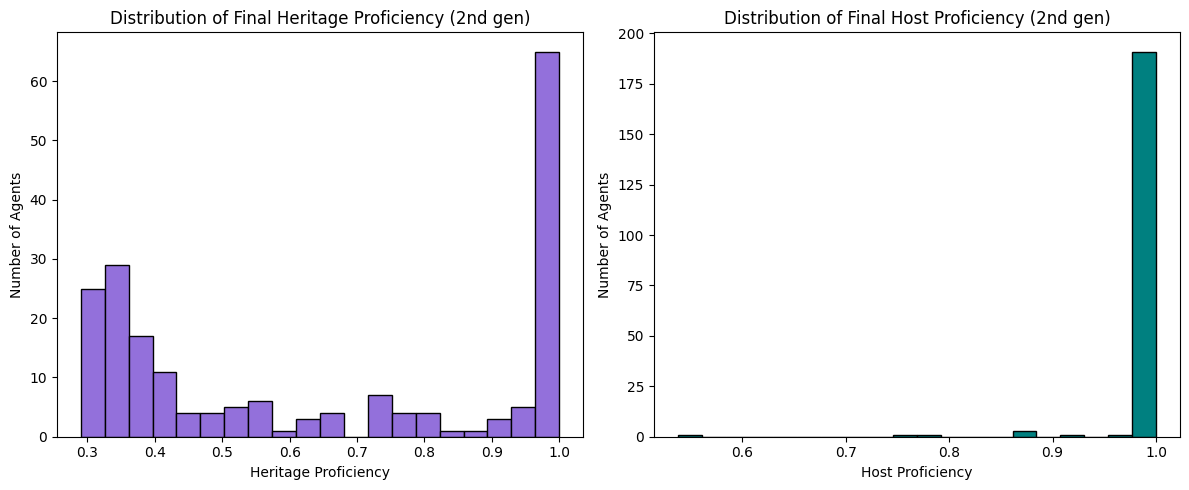

In [ ]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random
import math
import cupy as cp

# =========================
# PARENT DEFINITION
# =========================
class Parent:
    """
    Represents a parent, either first-gen or host.
    first-gen: heritage=1, host in [0,1]
    host: heritage=0, host=1
    """
    def __init__(self, is_first_gen):
        if is_first_gen:
            self.heritage_proficiency = 1.0
            self.host_proficiency = random.uniform(0, 1)
        else:
            # host parent
            self.heritage_proficiency = 0.0
            self.host_proficiency = 1.0

# =========================
# HERITAGE PROPORTION LOGIC
# =========================
def compute_home_language_fraction(agent, parent1, parent2):
    a_heritage = agent.proficiency["heritage"]
    a_host = agent.proficiency["host"]
    total_agent = a_heritage + a_host
    if total_agent > 0:
        p_A = a_heritage / total_agent
    else:
        p_A = 0.0

    def parent_fraction(parent):
        total_parent = parent.heritage_proficiency + parent.host_proficiency
        return parent.heritage_proficiency / total_parent if total_parent > 0 else 0.0

    f1 = parent_fraction(parent1)
    f2 = parent_fraction(parent2)
    f_P = (f1 + f2) / 2.0

    time_spent_speaking_heritage = (f_P * p_A)

    return time_spent_speaking_heritage

# designed to handle a inputs from [0,2]
def sigmoid(x, k=5, x0=1):
    return 1.0 / (1 + math.exp(-k * (x - x0))) if x > 0 else 0.0

# =========================
# AGENT DEFINITION
# =========================
class Agent:
    def __init__(self, id, position, agent_type,
                 parent1, parent2, init_heritage=0.0,
                 init_host=1.0):
        """
        agent_type: 'host' or 'second_gen'
        parent1, parent2: Parent objects
        learning_rate, motivation: float
        family_weight: float in [0,1] that scales the daily household update
        init_heritage, init_host: initial proficiencies
        """
        self.id = id
        self.position = position
        self.agent_type = agent_type
        self.parent1 = parent1
        self.parent2 = parent2
        self.proficiency = {
            "heritage": init_heritage,
            "host": init_host
        }
        self.history = {
            "heritage": [init_heritage],
            "host": [init_host]
        }

    def update_position(self, delta=0.01):
        x, y = self.position
        new_x = np.clip(x + random.uniform(-delta, delta), 0, 1)
        new_y = np.clip(y + random.uniform(-delta, delta), 0, 1)
        self.position = (new_x, new_y)

    def update_proficiency(self, phys_neighbors, social_neighbors):
        if self.agent_type == "host":
            self.history["heritage"].append(self.proficiency["heritage"])
            self.history["host"].append(self.proficiency["host"])
            return

        # ============ 1) SOCIAL & PHYSICAL UPDATE ============
        host_interaction_weight = 0.0
        max_weight = 0
        for neighbor, dist in phys_neighbors:
            weight = 1.0 / dist if dist > 0 else 10.0
            max_weight = max(max_weight, weight)
            host_interaction_weight += weight * neighbor.proficiency["host"]

        host_interaction_weight += sum(max_weight for n in social_neighbors)

        num_neighbors = len(phys_neighbors) + len(social_neighbors)
        host_interaction_weight /= num_neighbors * max_weight

        alpha = 0.01 # constant to reduce the impact of host interactions

        self.proficiency["host"] = alpha * host_interaction_weight + self.proficiency["host"]
        if self.proficiency["host"] > 1: self.proficiency["host"] = 1

        # ============ 2) FAMILY INTERACTION UPDATE ============
        time_spent_speaking_heritage = compute_home_language_fraction(self, self.parent1, self.parent2)
        time_spent_speaking_host = 1 - time_spent_speaking_heritage

        self.proficiency["heritage"] = sigmoid(time_spent_speaking_heritage) + self.proficiency["heritage"]
        self.proficiency["host"] = sigmoid(time_spent_speaking_host) + self.proficiency["host"]

        if self.proficiency["heritage"] > 1: self.proficiency["heritage"] = 1
        if self. proficiency["host"] > 1: self.proficiency["host"] = 1

        self.history["heritage"].append(self.proficiency["heritage"])
        self.history["host"].append(self.proficiency["host"])


# =========================
# GPU-ACCEL PHYSICAL NEIGHBORS
# =========================
def compute_physical_neighbors_gpu(agents, threshold):
    N = len(agents)
    positions = cp.array([agent.position for agent in agents])
    diff = positions[:, cp.newaxis, :] - positions[cp.newaxis, :, :]
    dists = cp.linalg.norm(diff, axis=2)
    mask = (dists < threshold) & (dists > 0)
    phys_neighbors = {agent.id: [] for agent in agents}
    for i in range(N):
        neighbor_indices = cp.where(mask[i])[0]
        neighbor_dists = cp.asnumpy(dists[i, neighbor_indices])
        neighbors = [agents[int(idx)] for idx in cp.asnumpy(neighbor_indices)]
        phys_neighbors[agents[i].id] = list(zip(neighbors, neighbor_dists))
    return phys_neighbors

# =========================
# CREATE PARENTS
# =========================
def create_parents_for_second_gen():
    """
    Return (parent1, parent2, family_weight).
    parent1, parent2 are Parent objects.
    family_weight depends on how many parents are first-gen.
    """
    # parent1 is guaranteed first-gen => heritage=1, host in [0,1]
    parent1 = Parent(is_first_gen=True)

    if random.random() < 0.5:
        parent2 = Parent(is_first_gen=True)
    else:
        parent2 = Parent(is_first_gen=False)

    return parent1, parent2
# =========================
# MAIN SIMULATION
# =========================
def run_simulation():
    N = 1000
    T = 20
    phys_threshold = 0.1
    social_prob = 0.02

    host_fraction = 0.8
    second_gen_count = int((1 - host_fraction) * N)
    host_count = N - second_gen_count

    # Create Agents
    agents = []
    for i in range(N):
        x = random.uniform(0, 1)
        y = random.uniform(0, 1)
        pos = (x, y)

        if i < host_count:
            parent1 = Parent(is_first_gen=False)
            parent2 = Parent(is_first_gen=False)
            agent = Agent(i, pos, "host", parent1, parent2,
                          init_heritage=0.0, init_host=1.0)
        else:
            # Second-gen agent
            parent1, parent2 = create_parents_for_second_gen()
            init_herit = random.uniform(0.1, 0.15)
            init_host = 0 #random.uniform(0.4, 0.7)
            agent = Agent(i, pos, "second_gen", parent1, parent2,
                          init_heritage=init_herit, init_host=init_host)
        agents.append(agent)

    # Create social network (static)
    social_G = nx.erdos_renyi_graph(N, social_prob)
    social_neighbors = {i: [] for i in range(N)}
    for u, v in social_G.edges():
        social_neighbors[u].append(agents[v])
        social_neighbors[v].append(agents[u])

    # Simulation loop
    for t in range(T):
        for agent in agents:
            agent.update_position(delta=0.01)

        phys_neighbors = compute_physical_neighbors_gpu(agents, phys_threshold)

        for agent in agents:
            p_neighbors = phys_neighbors[agent.id]
            s_neighbors = social_neighbors[agent.id]
            agent.update_proficiency(p_neighbors, s_neighbors)

    return agents

# =========================
# RUN SIMULATION
# =========================
if __name__ == "__main__":
    agents = run_simulation()

    second_gen_agents = [a for a in agents if a.proficiency["heritage"] != 0]

    heritage_final = [a.proficiency["heritage"] for a in second_gen_agents]
    host_final = [a.proficiency["host"] for a in second_gen_agents]

    print(f"Average final heritage proficiency (2nd gen): {np.mean(heritage_final):.3f}")
    print(f"Average final host proficiency (2nd gen): {np.mean(host_final):.3f}")

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.hist(heritage_final, bins=20, color='mediumpurple', edgecolor='black')
    plt.xlabel("Heritage Proficiency")
    plt.ylabel("Number of Agents")
    plt.title("Distribution of Final Heritage Proficiency (2nd gen)")

    plt.subplot(1, 2, 2)
    plt.hist(host_final, bins=20, color='teal', edgecolor='black')
    plt.xlabel("Host Proficiency")
    plt.ylabel("Number of Agents")
    plt.title("Distribution of Final Host Proficiency (2nd gen)")

    plt.tight_layout()
    plt.show()




Average final heritage proficiency (2nd gen): 0.592
Average final host proficiency (2nd gen): 0.993

--- Heritage=1.0 vs. <1.0 ---
Number with heritage=1.0: 48
Number with heritage<1.0: 151
Avg parent heritage (H=1.0 group): 1.000, host: 0.324
Avg parent heritage (<1.0 group): 0.656, host: 0.727

--- 2 vs. 1 First-Gen Parent ---
Number of 2-first-gen agents: 95
Number of 1-first-gen agents: 104
Avg final heritage (2 parents) = 0.850
Avg final heritage (1 parent) = 0.357


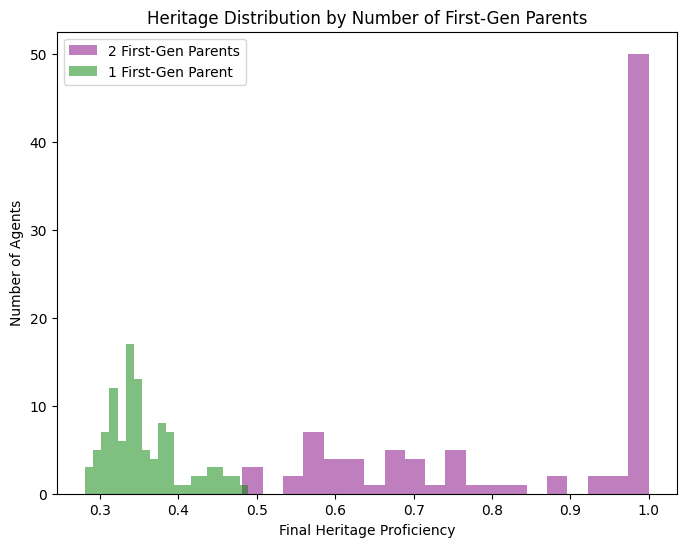

Agents with 2 first-gen parents: 95
  -> Reached heritage=1.0: 48
  -> Remained <1.0:       47

--- Parent Proficiency Averages (2 FGen) ---
Heritage=1.0 group: parent heritage=1.00, host=0.32
Heritage<1.0 group: parent heritage=1.00, host=0.69


In [ ]:
def analyze_results(agents, social_threshold=0.1):
    """
    1) Recompute physical neighbors for final positions.
    2) Filter second-gen agents.
    3) Compare agents with final heritage=1.0 vs. <1.0.
    4) Compare agents with two vs. one first-gen parent.
    """

    # === 1) Recompute physical neighbors for final positions ===
    phys_neighbors = compute_physical_neighbors_gpu(agents, threshold=social_threshold)
    second_gen_agents = [a for a in agents if a.agent_type == "second_gen"]

    heritage_final = [a.proficiency["heritage"] for a in second_gen_agents]
    host_final = [a.proficiency["host"] for a in second_gen_agents]

    print(f"Average final heritage proficiency (2nd gen): {np.mean(heritage_final):.3f}")
    print(f"Average final host proficiency (2nd gen): {np.mean(host_final):.3f}")

    # === 3) Compare agents with final heritage = 1.0 vs. <1.0 ===
    fully_herit_agents = [a for a in second_gen_agents if abs(a.proficiency["heritage"] - 1.0) < 1e-9]
    partial_herit_agents = [a for a in second_gen_agents if a.proficiency["heritage"] < 1.0]

    print("\n--- Heritage=1.0 vs. <1.0 ---")
    print(f"Number with heritage=1.0: {len(fully_herit_agents)}")
    print(f"Number with heritage<1.0: {len(partial_herit_agents)}")

    # 3a) Average parent proficiencies
    def average_parent_proficiencies(agents_list):
        h_vals, g_vals = [], []
        for ag in agents_list:
            p1h, p1g = ag.parent1.heritage_proficiency, ag.parent1.host_proficiency
            p2h, p2g = ag.parent2.heritage_proficiency, ag.parent2.host_proficiency
            h_vals.extend([p1h, p2h])
            g_vals.extend([p1g, p2g])
        return (np.mean(h_vals), np.mean(g_vals)) if len(h_vals) > 0 else (0, 0)

    avg_h_fully, avg_g_fully = average_parent_proficiencies(fully_herit_agents)
    avg_h_partial, avg_g_partial = average_parent_proficiencies(partial_herit_agents)

    print(f"Avg parent heritage (H=1.0 group): {avg_h_fully:.3f}, host: {avg_g_fully:.3f}")
    print(f"Avg parent heritage (<1.0 group): {avg_h_partial:.3f}, host: {avg_g_partial:.3f}")


    # === 4) Compare agents with two vs. one first-gen parent ===
    def num_first_gen_parents(agent):
        # We'll define "first-gen" as parent.heritage_proficiency == 1.0
        count = 0
        if abs(agent.parent1.heritage_proficiency - 1.0) < 1e-9:
            count += 1
        if abs(agent.parent2.heritage_proficiency - 1.0) < 1e-9:
            count += 1
        return count

    two_first_gen = [ag for ag in second_gen_agents if num_first_gen_parents(ag) == 2]
    one_first_gen  = [ag for ag in second_gen_agents if num_first_gen_parents(ag) == 1]

    heritage_two = [a.proficiency["heritage"] for a in two_first_gen]
    heritage_one = [a.proficiency["heritage"] for a in one_first_gen]

    print(f"\n--- 2 vs. 1 First-Gen Parent ---")
    print(f"Number of 2-first-gen agents: {len(two_first_gen)}")
    print(f"Number of 1-first-gen agents: {len(one_first_gen)}")
    print(f"Avg final heritage (2 parents) = {np.mean(heritage_two):.3f}")
    print(f"Avg final heritage (1 parent) = {np.mean(heritage_one):.3f}")

    # 4a) Plot separate histograms
    plt.figure(figsize=(8,6))
    plt.hist(heritage_two, bins=20, alpha=0.5, color='purple', label='2 First-Gen Parents')
    plt.hist(heritage_one, bins=20, alpha=0.5, color='green', label='1 First-Gen Parent')
    plt.xlabel("Final Heritage Proficiency")
    plt.ylabel("Number of Agents")
    plt.title("Heritage Distribution by Number of First-Gen Parents")
    plt.legend()
    plt.show()

    def num_first_gen_parents(agent):
        """Returns how many of this agent's parents have heritage_proficiency = 1.0."""
        count = 0
        if abs(agent.parent1.heritage_proficiency - 1.0) < 1e-9:
            count += 1
        if abs(agent.parent2.heritage_proficiency - 1.0) < 1e-9:
            count += 1
        return count

    # Filter second-gen agents who have exactly 2 first-gen parents
    two_first_gen = [ag for ag in second_gen_agents if num_first_gen_parents(ag) == 2]

    # Among those, separate out who reached heritage=1.0 vs. those who did not
    two_fg_fully = [ag for ag in two_first_gen if abs(ag.proficiency["heritage"] - 1.0) < 1e-9]
    two_fg_partial = [ag for ag in two_first_gen if ag.proficiency["heritage"] < 1.0]

    print(f"Agents with 2 first-gen parents: {len(two_first_gen)}")
    print(f"  -> Reached heritage=1.0: {len(two_fg_fully)}")
    print(f"  -> Remained <1.0:       {len(two_fg_partial)}")

    def average_parent_proficiencies(agents_list):
        h_vals, g_vals = [], []
        for ag in agents_list:
            h_vals.extend([ag.parent1.heritage_proficiency, ag.parent2.heritage_proficiency])
            g_vals.extend([ag.parent1.host_proficiency, ag.parent2.host_proficiency])
        if len(h_vals) == 0:
            return (0, 0)
        return (np.mean(h_vals), np.mean(g_vals))

    avg_h_fully, avg_g_fully = average_parent_proficiencies(two_fg_fully)
    avg_h_partial, avg_g_partial = average_parent_proficiencies(two_fg_partial)

    print("\n--- Parent Proficiency Averages (2 FGen) ---")
    print(f"Heritage=1.0 group: parent heritage={avg_h_fully:.2f}, host={avg_g_fully:.2f}")
    print(f"Heritage<1.0 group: parent heritage={avg_h_partial:.2f}, host={avg_g_partial:.2f}")



analyze_results(agents, social_threshold=0.1)

Number of second-gen agents with 2 first-gen parents:
  Fully proficient (heritage=1.0): 48
  Non fully proficient (heritage < 1.0): 47


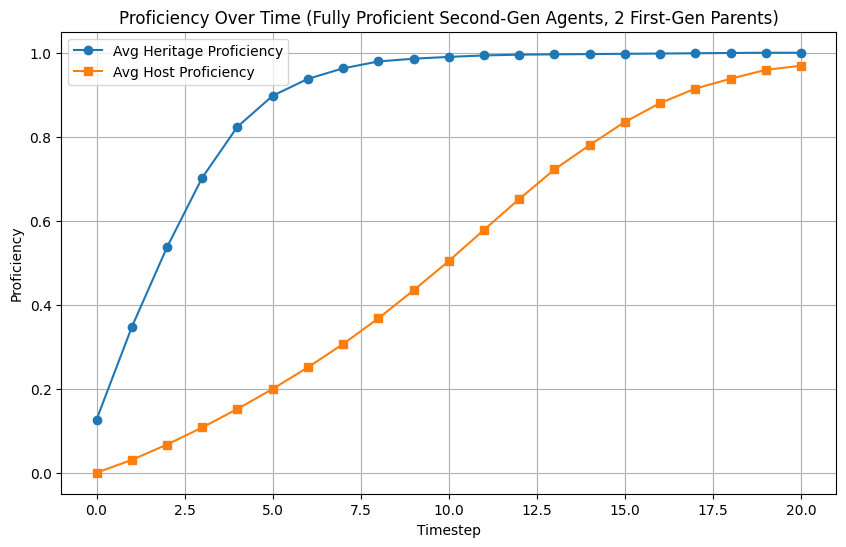

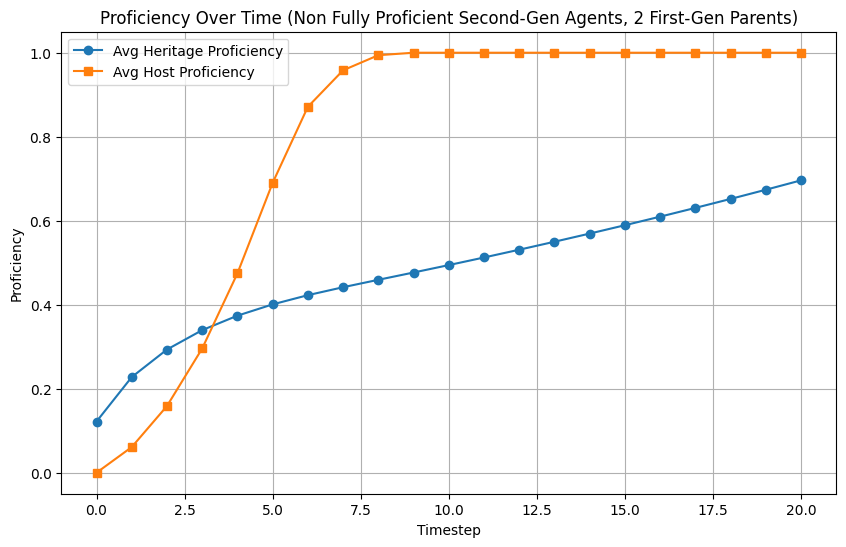

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Helper function to count number of first-gen parents (we define first-gen as having heritage_proficiency ≈ 1.0)
def num_first_gen_parents(agent, tol=1e-9):
    count = 0
    if abs(agent.parent1.heritage_proficiency - 1.0) < tol:
        count += 1
    if abs(agent.parent2.heritage_proficiency - 1.0) < tol:
        count += 1
    return count

# --- Filter agents ---
# Assume 'agents' is the list returned by your simulation.
# Filter second-gen agents with exactly two first-gen parents.
two_fg_agents = [a for a in agents if a.agent_type == "second_gen" and num_first_gen_parents(a) == 2]

# Further separate into:
# Group A: Agents that reached full heritage proficiency (heritage ≈ 1.0 at final timestep)
# Group B: Agents that did not reach full proficiency (heritage < 1.0 at final timestep)
tol = 1e-9
fully_proficient_agents = [a for a in two_fg_agents if abs(a.history["heritage"][-1] - 1.0) < tol]
non_fully_proficient_agents = [a for a in two_fg_agents if a.history["heritage"][-1] < 1.0]

print("Number of second-gen agents with 2 first-gen parents:")
print("  Fully proficient (heritage=1.0):", len(fully_proficient_agents))
print("  Non fully proficient (heritage < 1.0):", len(non_fully_proficient_agents))

# --- Compute average proficiency histories for each group ---
# We assume each agent's history is a list (over timesteps) in agent.history["heritage"] and agent.history["host"]
if two_fg_agents:
    T = len(two_fg_agents[0].history["heritage"])  # total timesteps
else:
    T = 0

time_steps = np.arange(T)

def compute_average_history(agent_list, T):
    avg_herit = np.zeros(T)
    avg_host = np.zeros(T)
    for t in range(T):
        avg_herit[t] = np.mean([a.history["heritage"][t] for a in agent_list])
        avg_host[t] = np.mean([a.history["host"][t] for a in agent_list])
    return avg_herit, avg_host

avg_herit_fully, avg_host_fully = compute_average_history(fully_proficient_agents, T)
avg_herit_nonfully, avg_host_nonfully = compute_average_history(non_fully_proficient_agents, T)

# --- Plotting ---

# Plot for fully proficient agents (Group A)
plt.figure(figsize=(10,6))
plt.plot(time_steps, avg_herit_fully, marker='o', label="Avg Heritage Proficiency")
plt.plot(time_steps, avg_host_fully, marker='s', label="Avg Host Proficiency")
plt.xlabel("Timestep")
plt.ylabel("Proficiency")
plt.title("Proficiency Over Time (Fully Proficient Second-Gen Agents, 2 First-Gen Parents)")
plt.legend()
plt.grid(True)
plt.show()

# Plot for non fully proficient agents (Group B)
plt.figure(figsize=(10,6))
plt.plot(time_steps, avg_herit_nonfully, marker='o', label="Avg Heritage Proficiency")
plt.plot(time_steps, avg_host_nonfully, marker='s', label="Avg Host Proficiency")
plt.xlabel("Timestep")
plt.ylabel("Proficiency")
plt.title("Proficiency Over Time (Non Fully Proficient Second-Gen Agents, 2 First-Gen Parents)")
plt.legend()
plt.grid(True)
plt.show()
